In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%env THEANO_FLAGS=device=cpu,floatX=float32

env: THEANO_FLAGS=device=cpu,floatX=float32


In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import pickle

import theano

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
import theano.tensor as tt
from theano.tensor.nlinalg import det
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Generate some data

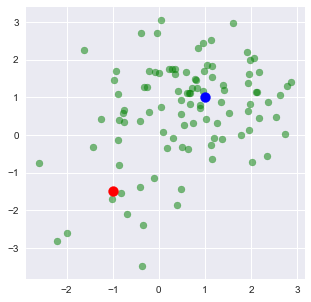

In [3]:
n_samples = 100
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1]])
ps = np.array([0.2, 0.8])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)

## Define the model

In [109]:
from pymc3.math import logsumexp

# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    # TODO: why is this a function? why not compute it once? 
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    # TODO: clean up a bit using zip
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(2)),
                    tau=pm.floatX(0.1 * np.eye(2)),
                    shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

## Run model with MCMC

In [5]:
with model:
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start)

logp = -384.33, ||grad|| = 62.173: 100%|██████████| 4/4 [00:00<00:00, 1025.06it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [pi]
>Metropolis: [mu_1]
>Metropolis: [mu_0]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3228.70draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


## Plot MCMC samples

(-6, 6)

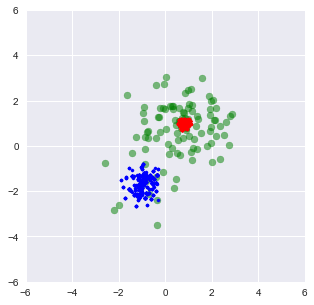

In [6]:
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
mu_0, mu_1 = trace['mu_0'], trace['mu_1']
plt.scatter(mu_0[-500:, 0], mu_0[-500:, 1], c="r", s=10)
plt.scatter(mu_1[-500:, 0], mu_1[-500:, 1], c="b", s=10)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

## Run with ADVI

In [110]:
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

with model:
    %time approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))

means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov)**.5)

Average Loss = 1.1531e+06: 100%|██████████| 4500/4500 [01:28<00:00, 50.83it/s]
Finished [100%]: Average Loss = 1.1531e+06


CPU times: user 5min 39s, sys: 12.1 s, total: 5min 52s
Wall time: 1min 32s


/Users/guydavidson/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


## Plot ADVI results

(-6, 6)

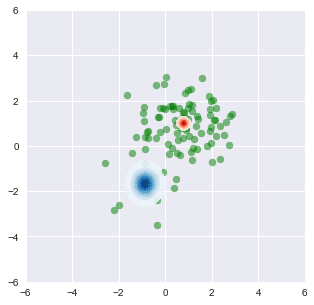

In [8]:
from copy import deepcopy

mu_0, sd_0 = means['mu_0'], sds['mu_0']
mu_1, sd_1 = means['mu_1'], sds['mu_1']

def logp_normal_np(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * np.log(2 * np.pi) + np.log(1./np.linalg.det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

def threshold(zz):
    zz_ = deepcopy(zz)
    zz_[zz < np.max(zz) * 1e-2] = None
    return zz_

def plot_logp_normal(ax, mu, sd, cmap):
    f = lambda value: np.exp(logp_normal_np(mu, np.diag(1 / sd**2), value))
    g = lambda mu, sd: np.arange(mu - 3, mu + 3, .1)
    xx, yy = np.meshgrid(g(mu[0], sd[0]), g(mu[1], sd[1]))
    zz = f(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).reshape(xx.shape)
    ax.contourf(xx, yy, threshold(zz), cmap=cmap, alpha=0.9)

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
plot_logp_normal(ax, mu_0, sd_0, cmap='Reds')
plot_logp_normal(ax, mu_1, sd_1, cmap='Blues')
plt.xlim(-6, 6)
plt.ylim(-6, 6)

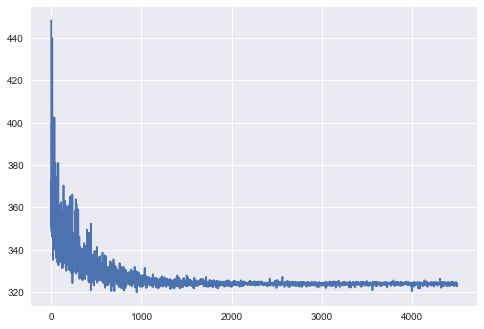

In [9]:
plt.plot(approx.hist)


## Create a large dataset

(-6, 6)

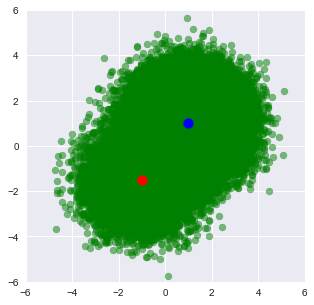

In [10]:
n_samples = 100000

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

## Run it with MCMC

In [11]:
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start)

logp = -3.6535e+05, ||grad|| = 0.0040229: 100%|██████████| 44/44 [00:00<00:00, 51.16it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [pi]
>Metropolis: [mu_1]
>Metropolis: [mu_0]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:57<00:00, 51.00draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


## Plot MCMC samples

(-6, 6)

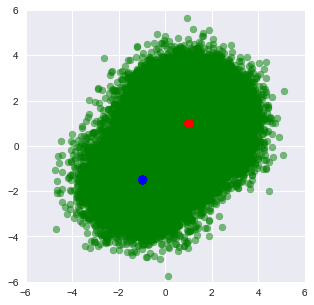

In [12]:
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
mu_0, mu_1 = trace['mu_0'], trace['mu_1']
plt.scatter(mu_0[-500:, 0], mu_0[-500:, 1], c="r", s=50)
plt.scatter(mu_1[-500:, 0], mu_1[-500:, 1], c="b", s=50)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

## Run ADVI on the large dataset, with minibatches

In [13]:
minibatch_size = 200
# In memory Minibatches for better speed
data_t = pm.Minibatch(data, minibatch_size)

with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data_t, total_size=len(data))

/Users/guydavidson/anaconda/lib/python3.6/site-packages/pymc3/data.py:236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [14]:
def f():
    approx = pm.fit(n=1500, obj_optimizer=pm.adagrad(learning_rate=1e-1), model=model)
    means = approx.bij.rmap(approx.mean.eval())
    sds = approx.bij.rmap(approx.std.eval())
    return means, sds, approx.hist

%time means, sds, elbos = f()

Average Loss = 653.04: 100%|██████████| 1500/1500 [00:00<00:00, 2474.27it/s]
Finished [100%]: Average Loss = 652.88


CPU times: user 3.55 s, sys: 415 ms, total: 3.97 s
Wall time: 15.5 s


(-6, 6)

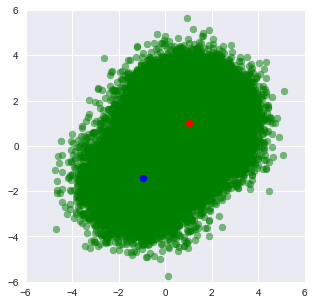

In [15]:
mu_0, sd_0 = means['mu_0'], sds['mu_0']
mu_1, sd_1 = means['mu_1'], sds['mu_1']

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
plt.scatter(mu_0[0], mu_0[1], c="r", s=50)
plt.scatter(mu_1[0], mu_1[1], c="b", s=50)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

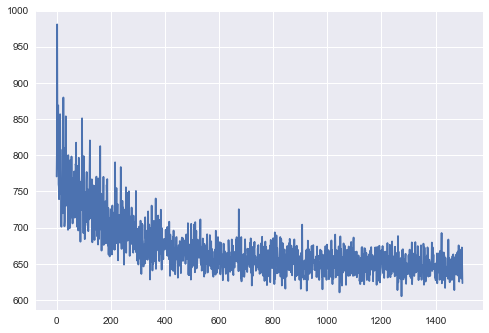

In [16]:
plt.plot(elbos);


## Extend model to more clusters

### Generate some data with four clusters

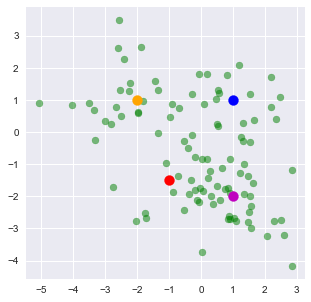

In [15]:
n_samples = 100
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1], [-2, 1], [1, -2]])
ps = np.array([0.1, 0.2, 0.3, 0.4])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)
plt.scatter(ms[2, 0], ms[2, 1], c='orange', s=100)
plt.scatter(ms[3, 0], ms[3, 1], c='m', s=100)

In [12]:
from pymc3.math import logsumexp


# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    # TODO: why is this a function? why not compute it once? 
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))


# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    # TODO: clean up a bit using zip - this actually breaks the model badly
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

N_MEANS = 4

with pm.Model() as model:
    mc_mus = [MvNormal('mc_mu_%d' % i,
                    mu=pm.floatX(np.zeros(2)),
                    tau=pm.floatX(0.1 * np.eye(2)),
                    shape=(2,))
           for i in range(N_MEANS)]
    mc_pi = Dirichlet('mc_pi', a=pm.floatX(0.1 * np.ones(N_MEANS)), shape=(N_MEANS,))
    xs = DensityDist('x', logp_gmix(mc_mus, mc_pi, np.eye(2)), observed=data)

In [13]:
with model:
    %time approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))

means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov)**.5)

Average Loss = 392.77: 100%|██████████| 4500/4500 [00:01<00:00, 2430.90it/s]
Finished [100%]: Average Loss = 392.77


CPU times: user 6.11 s, sys: 630 ms, total: 6.74 s
Wall time: 17.1 s


/Users/guydavidson/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


(-6, 6)

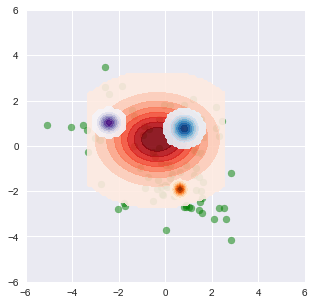

In [16]:
from copy import deepcopy

mus = [means[f'mc_mu_{i}'] for i in range(N_MEANS)]
sds = [sds[f'mc_mu_{i}'] for i in range(N_MEANS)]

def logp_normal_np(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * np.log(2 * np.pi) + np.log(1./np.linalg.det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

def threshold(zz):
    zz_ = deepcopy(zz)
    zz_[zz < np.max(zz) * 1e-2] = None
    return zz_

def plot_logp_normal(ax, mu, sd, cmap):
    f = lambda value: np.exp(logp_normal_np(mu, np.diag(1 / sd**2), value))
    g = lambda mu, sd: np.arange(mu - 3, mu + 3, .1)
    xx, yy = np.meshgrid(g(mu[0], sd[0]), g(mu[1], sd[1]))
    zz = f(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).reshape(xx.shape)
    ax.contourf(xx, yy, threshold(zz), cmap=cmap, alpha=0.9)

    
cmaps = ('Reds', 'Blues', 'Oranges', 'Purples')
    
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')

for mu, sd, cmap in zip(mus, sds, cmaps):
    plot_logp_normal(ax, mu, sd, cmap=cmap)
    
plt.xlim(-6, 6)
plt.ylim(-6, 6)

### Unrecoverable. That's sad. What if we add more data?

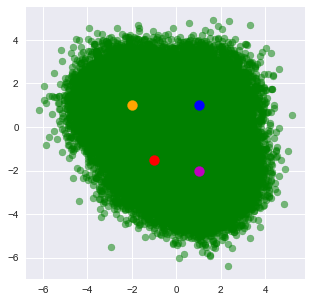

In [19]:
n_samples = 100000
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1], [-2, 1], [1, -2]])
ps = np.array([0.1, 0.2, 0.3, 0.4])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)
plt.scatter(ms[2, 0], ms[2, 1], c='orange', s=100)
plt.scatter(ms[3, 0], ms[3, 1], c='m', s=100)

In [20]:
minibatch_size = 200
# In memory Minibatches for better speed
data_t = pm.Minibatch(data, minibatch_size)

with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(N_MEANS)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(N_MEANS)), shape=(N_MEANS,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data_t, total_size=len(data))

/Users/guydavidson/anaconda/lib/python3.6/site-packages/pymc3/data.py:236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [21]:
def f():
    approx = pm.fit(n=1500, obj_optimizer=pm.adagrad(learning_rate=1e-1), model=model)
    means = approx.bij.rmap(approx.mean.eval())
    sds = approx.bij.rmap(approx.std.eval())
    return means, sds, approx.hist

%time means, sds, elbos = f()

Average Loss = 765.61: 100%|██████████| 1500/1500 [00:00<00:00, 1911.99it/s]
Finished [100%]: Average Loss = 765.45


CPU times: user 4.01 s, sys: 135 ms, total: 4.15 s
Wall time: 5.1 s


(-6, 6)

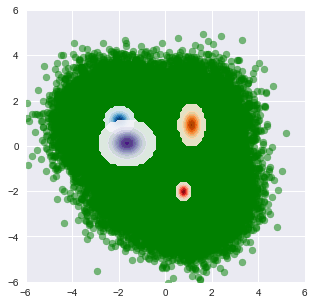

In [23]:
mus = [means[f'mu_{i}'] for i in range(N_MEANS)]
sds = [sds[f'mu_{i}'] for i in range(N_MEANS)]    
cmaps = ('Reds', 'Blues', 'Oranges', 'Purples')
    
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')

for mu, sd, cmap in zip(mus, sds, cmaps):
    plot_logp_normal(ax, mu, sd, cmap=cmap)
    
plt.xlim(-6, 6)
plt.ylim(-6, 6)

### Looks like too much overlap to actually succeed. Let's shift them further apart just for an example:

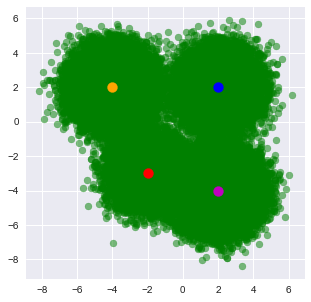

In [24]:
n_samples = 100000
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1], [-2, 1], [1, -2]]) * 2
ps = np.array([0.1, 0.2, 0.3, 0.4])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)
plt.scatter(ms[2, 0], ms[2, 1], c='orange', s=100)
plt.scatter(ms[3, 0], ms[3, 1], c='m', s=100)

In [25]:
minibatch_size = 200
# In memory Minibatches for better speed
data_t = pm.Minibatch(data, minibatch_size)

with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(N_MEANS)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(N_MEANS)), shape=(N_MEANS,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data_t, total_size=len(data))

/Users/guydavidson/anaconda/lib/python3.6/site-packages/pymc3/data.py:236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [27]:
def f():
    approx = pm.fit(n=1500, obj_optimizer=pm.adagrad(learning_rate=1e-1), model=model)
    means = approx.bij.rmap(approx.mean.eval())
    sds = approx.bij.rmap(approx.std.eval())
    return means, sds, approx.hist

%time means, sds, elbos = f()

Average Loss = 1,010.8: 100%|██████████| 1500/1500 [00:00<00:00, 1848.72it/s]
Finished [100%]: Average Loss = 1,008.9


CPU times: user 4.15 s, sys: 101 ms, total: 4.25 s
Wall time: 4.26 s


(-6, 6)

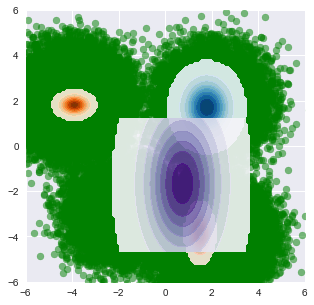

In [28]:
mus = [means[f'mu_{i}'] for i in range(N_MEANS)]
sds = [sds[f'mu_{i}'] for i in range(N_MEANS)]    
cmaps = ('Reds', 'Blues', 'Oranges', 'Purples')
    
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')

for mu, sd, cmap in zip(mus, sds, cmaps):
    plot_logp_normal(ax, mu, sd, cmap=cmap)
    
plt.xlim(-6, 6)
plt.ylim(-6, 6)

## Out of curiosity, what if I decided each cluster has a Cauchy likelihood
The bivariate Cauchy has the following likelihood:
\begin{align*}
f(x, y; x_0, y_0 \gamma) &= \frac{\gamma }{2 \pi} \left[ \frac{1}{(x-x_0)^2 + (y-y_0)^2 + \gamma^2} \right]^{1.5}  \\
\log f(x, y; x_0, y_0 \gamma) &= \log \left( \frac{\gamma }{2 \pi} \right) + \log \left[ \frac{1}{(x-x_0)^2 + (y-y_0)^2 + \gamma^2} \right]^{1.5}  \\
\log f(x, y; x_0, y_0 \gamma) &= \log \gamma - \log (2\pi) - 1.5 \log \left[ (x-x_0)^2 + (y-y_0)^2 + \gamma^2 \right]
\end{align*}

In [34]:
from pymc3.math import logsumexp


# Log likelihood of normal distribution
def logp_cauchy(x_0, gamma, value):
    # log probability of individual samples
    # TODO: why is this a function? why not compute it once? 
    delta = lambda x_0: value - x_0
    return tt.log(gamma) - tt.log(2 * np.pi) - 1.5 * tt.log(tt.square(delta(x_0)).sum(axis=1) + tt.square(gamma))


# Log likelihood of Gaussian mixture distribution
def logp_cauchy_mix(x_0s, pi, gamma):
    # TODO: clean up a bit using zip - this actually breaks the model badly
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_cauchy(x_0, gamma, value)
                 for i, x_0 in enumerate(x_0s)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

N_MEANS = 4


minibatch_size = 200
# In memory Minibatches for better speed
data_t = pm.Minibatch(data, minibatch_size)

with pm.Model() as cauchy_model:
    cauchy_x_0s = [MvNormal('cauchy_x0_%d' % i,
                    mu=pm.floatX(np.zeros(2)),
                    tau=pm.floatX(0.1 * np.eye(2)),
                    shape=(2,))
           for i in range(N_MEANS)]
    cauchy_pi = Dirichlet('cacuchy_pi', a=pm.floatX(0.1 * np.ones(N_MEANS)), shape=(N_MEANS,))
    xs = DensityDist('x', logp_cauchy_mix(cauchy_x_0s, cauchy_pi, np.ones(1)), 
                     observed=data_t, total_size=len(data))

/Users/guydavidson/anaconda/lib/python3.6/site-packages/pymc3/data.py:236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [35]:
def f():
    approx = pm.fit(n=1500, obj_optimizer=pm.adagrad(learning_rate=1e-1), model=cauchy_model)
    means = approx.bij.rmap(approx.mean.eval())
    sds = approx.bij.rmap(approx.std.eval())
    return means, sds, approx.hist

%time means, sds, elbos = f()

Average Loss = 919.78: 100%|██████████| 1500/1500 [00:00<00:00, 2133.25it/s]
Finished [100%]: Average Loss = 919.34


CPU times: user 3.88 s, sys: 207 ms, total: 4.08 s
Wall time: 8.49 s


(-6, 6)

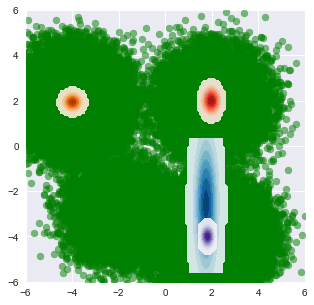

In [39]:
mus = [means[f'cauchy_x0_{i}'] for i in range(N_MEANS)]
sds = [sds[f'cauchy_x0_{i}'] for i in range(N_MEANS)]    
cmaps = ('Reds', 'Blues', 'Oranges', 'Purples')
    
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')

for mu, sd, cmap in zip(mus, sds, cmaps):
    plot_logp_normal(ax, mu, sd, cmap=cmap)
    
plt.xlim(-6, 6)
plt.ylim(-6, 6)

## Another potential model tweak - learn the SDs as well

Let's implement it two ways: one learning diagonal covariances per matrix, the other learning a full covariance using the Cholesky decomposition.

First, generate some data:

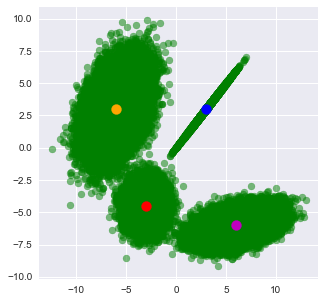

In [50]:
n_samples = 100000
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1], [-2, 1], [2, -2]]) * 3
covs = np.array([[[1, 0], [0, 1]], 
                 [[1, 1], [1, 1]],
                 [[2, 1], [1, 3]],
                 [[3, 0.5], [0.5, 0.5]]])
ps = np.array([0.1, 0.2, 0.3, 0.4])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, cov, size=n_samples)
      for z, m, cov in zip(zs, ms, covs)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)
plt.scatter(ms[2, 0], ms[2, 1], c='orange', s=100)
plt.scatter(ms[3, 0], ms[3, 1], c='m', s=100)

### Run the standard normal model

In [134]:
# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    # TODO: why is this a function? why not compute it once? 
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))


# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    # TODO: clean up a bit using zip - this actually breaks the model badly
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

N_MEANS = 4

with pm.Model() as model:
    mc_mus = [MvNormal('mc_mu_%d' % i,
                    mu=pm.floatX(np.zeros(2)),
                    tau=pm.floatX(0.1 * np.eye(2)),
                    shape=(2,))
           for i in range(N_MEANS)]
    mc_pi = Dirichlet('mc_pi', a=pm.floatX(0.1 * np.ones(N_MEANS)), shape=(N_MEANS,))
    xs = DensityDist('x', logp_gmix(mc_mus, mc_pi, np.eye(2)), observed=data)

In [66]:
def f():
    approx = pm.fit(n=1500, obj_optimizer=pm.adagrad(learning_rate=1e-1), model=model)
    means = approx.bij.rmap(approx.mean.eval())
    stddevs = approx.bij.rmap(approx.std.eval())
    return means, stddevs, approx.hist

%time means, stddevs, elbos = f()

Average Loss = 8.0993e+05: 100%|██████████| 1500/1500 [00:56<00:00, 26.34it/s]
Finished [100%]: Average Loss = 8.0624e+05


CPU times: user 3min 32s, sys: 10.9 s, total: 3min 43s
Wall time: 1min


(-10, 10)

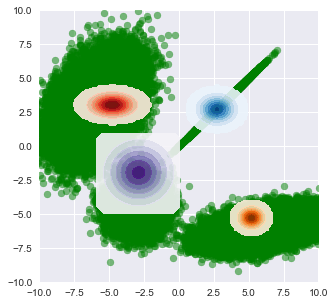

In [67]:
mus = [means[f'mc_mu_{i}'] for i in range(N_MEANS)]
sds = [stddevs[f'mc_mu_{i}'] for i in range(N_MEANS)]    
cmaps = ('Reds', 'Blues', 'Oranges', 'Purples')
    
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')

for mu, sd, cmap in zip(mus, sds, cmaps):
    plot_logp_normal(ax, mu, sd, cmap=cmap)
    
plt.xlim(-10, 10)
plt.ylim(-10, 10)

### Diagonal covariances

In [148]:
# Log likelihood of normal distribution

def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    # TODO: why is this a function? why not compute it once? 
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))


# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, taus):
    # TODO: clean up a bit using zip - this actually breaks the model badly
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mus[i], taus[i], value)
                 for i in range(len(mus))]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_


N_MEANS = 4


def exp_vec_to_diagonal_covariance(vec):
    return np.eye(2) * np.exp(vec)


minibatch_size = 200
# In memory Minibatches for better speed
data_t = pm.Minibatch(data, minibatch_size)

with pm.Model() as diagonal_cov_model:
    mus = [MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(2)),
                    tau=pm.floatX(0.1 * np.eye(2)),
                    shape=(2,))
           for i in range(N_MEANS)]
    tau_diags = [pm.Gamma('tau_diag_%d' % i, alpha=2.0, beta=1.0, shape=(2,)) 
                    for i in range(N_MEANS)]
    taus = [pm.Deterministic('tau_%d' % i, exp_vec_to_diagonal_covariance(tau_diags[i])) 
              for i in range(N_MEANS)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(N_MEANS)), shape=(N_MEANS,))
    xs = DensityDist('x', logp_gmix(mus, pi, taus), observed=data_t, total_size=len(data))

/Users/guydavidson/anaconda/lib/python3.6/site-packages/pymc3/data.py:236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


TypeError: __init__() got an unexpected keyword argument 'lower'

In [146]:
def f():
    approx = pm.fit(n=30000, obj_optimizer=pm.adagrad(learning_rate=1e-1), model=diagonal_cov_model)
    means = approx.bij.rmap(approx.mean.eval())
    stddevs = approx.bij.rmap(approx.std.eval())
    return approx, approx.hist

%time approx, elbos = f()

Average Loss = 1,002.8: 100%|██████████| 30000/30000 [00:27<00:00, 1108.96it/s]
Finished [100%]: Average Loss = 1,002.8


CPU times: user 30.8 s, sys: 408 ms, total: 31.2 s
Wall time: 31.2 s


(-10, 10)

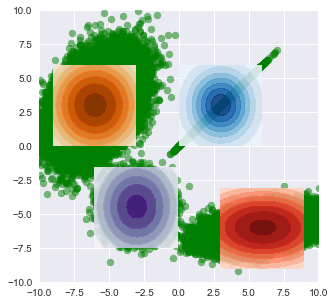

In [149]:
means = approx.bij.rmap(approx.mean.eval())
stddevs = approx.bij.rmap(approx.std.eval())

mus = [means[f'mu_{i}'] for i in range(N_MEANS)]
taus = [means[f'tau_diag_{i}_log__'] for i in range(N_MEANS)]    
cmaps = ('Reds', 'Blues', 'Oranges', 'Purples')
    
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')

def plot_logp_normal_precision(ax, mu, tau, cmap):
    f = lambda value: np.exp(logp_normal_np(mu, tau, value))
    g = lambda mu, sd: np.arange(mu - 3, mu + 3, .1)
    xx, yy = np.meshgrid(g(mu[0], sd[0]), g(mu[1], sd[1]))
    zz = f(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).reshape(xx.shape)
    ax.contourf(xx, yy, threshold(zz), cmap=cmap, alpha=0.9)

for mu, tau, cmap in zip(mus, taus, cmaps):
    tau_mat = exp_vec_to_diagonal_covariance(tau)
    plot_logp_normal_precision(ax, mu, tau_mat, cmap=cmap)
    
plt.xlim(-10, 10)
plt.ylim(-10, 10)

In [144]:
means

{'mu_0': array([2.6102097, 2.4748669], dtype=float32),
 'mu_1': array([-5.310236 ,  1.2062912], dtype=float32),
 'mu_2': array([3.3818152, 3.359562 ], dtype=float32),
 'mu_3': array([ 5.902179 , -5.9871345], dtype=float32),
 'pi_stickbreaking__': array([-1.1787753 ,  0.43969014, -1.3528033 ], dtype=float32),
 'tau_diag_0_log__': array([-1.1194961 , -0.50411505], dtype=float32),
 'tau_diag_1_log__': array([-1.9845028, -2.7735624], dtype=float32),
 'tau_diag_2_log__': array([-0.4704503 , -0.48008928], dtype=float32),
 'tau_diag_3_log__': array([-2.0032678, -1.484121 ], dtype=float32)}

### LKJ-Covariance

In [205]:
# Log likelihood of normal distribution


minibatch_size = 200
# In memory Minibatches for better speed
data_t = pm.Minibatch(data, minibatch_size)

with pm.Model() as lkj_model:
    mus = [MvNormal(f'mu_{i}',
                    mu=pm.floatX(np.zeros(2)),
                    tau=pm.floatX(0.1 * np.eye(2)),
                    shape=(2,))
           for i in range(N_MEANS)]
    packed_L = [pm.LKJCholeskyCov(f'packed_L_{i}', n=2,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5)) 
                    for i in range(N_MEANS)]
    L = [pm.expand_packed_triangular(2, packed_L[i])
         for i in range(N_MEANS)]
    taus = [pm.Deterministic(f'tau_{i}', L[i].dot(L[i].T)) 
              for i in range(N_MEANS)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(N_MEANS)), shape=(N_MEANS,))
    xs = DensityDist('x', logp_gmix(mus, pi, taus), observed=data_t, total_size=len(data))

/Users/guydavidson/anaconda/lib/python3.6/site-packages/pymc3/data.py:236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/Users/guydavidson/anaconda/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/guydavidson/anaconda/lib/python3.6/site-packages/theano/tensor/subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

In [206]:
# start = {'mu_0': np.array([2, 2]),
#         'mu_1': np.array([2, -2]),
#         'mu_2': np.array([-2, 2]),
#         'mu_3': np.array([-2, -2])}
start = {f'mu_{i}': rng.uniform(-4, 4, 2) for i in range(N_MEANS)}

def f():
    approx = pm.fit(n=30000, obj_optimizer=pm.adagrad(learning_rate=1e-1), 
                    model=lkj_model, start=start)
    means = approx.bij.rmap(approx.mean.eval())
    stddevs = approx.bij.rmap(approx.std.eval())
    return means, approx, approx.hist

%time lkj_means, lkj_approx, lkj_elbos = f()

  0%|          | 0/30000 [00:00<?, ?it/s]/Users/guydavidson/anaconda/lib/python3.6/site-packages/theano/tensor/subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/guydavidson/anaconda/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 795: 100%|██████████| 30000/30000 [00:46<00:00, 646.62it/s]   
Finished [100%]: Average Loss = 794.93


CPU times: user 54.9 s, sys: 4.37 s, total: 59.3 s
Wall time: 59.3 s


(-10, 10)

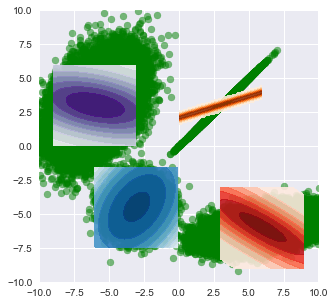

In [207]:
mus = [lkj_means[f'mu_{i}'] for i in range(N_MEANS)]
packed_Ls = [lkj_means[f'packed_L_{i}_cholesky-cov-packed__'] for i in range(N_MEANS)]    
cmaps = ('Reds', 'Blues', 'Oranges', 'Purples')
    
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')

def plot_logp_normal_precision(ax, mu, tau, cmap):
    f = lambda value: np.exp(logp_normal_np(mu, tau, value))
    g = lambda mu, sd: np.arange(mu - 3, mu + 3, .1)
    xx, yy = np.meshgrid(g(mu[0], sd[0]), g(mu[1], sd[1]))
    zz = f(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).reshape(xx.shape)
    ax.contourf(xx, yy, threshold(zz), cmap=cmap, alpha=0.9)

for mu, packed_L, cmap in zip(mus, packed_Ls, cmaps):
    L = np.eye(2)
    for i in range(packed_L.size):
        L[int(i > 0), int(i == 2)] = packed_L[i]
    tau_mat = L.dot(L.T)
    plot_logp_normal_precision(ax, mu, tau_mat, cmap=cmap)
    
plt.xlim(-10, 10)
plt.ylim(-10, 10)

## Generate some held-out data

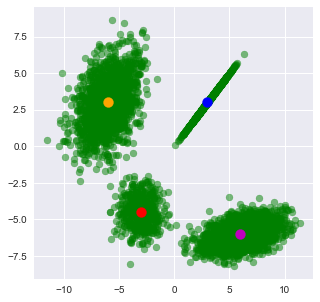

In [222]:
n_samples = 5000
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1], [-2, 1], [2, -2]]) * 3
covs = np.array([[[1, 0], [0, 1]], 
                 [[1, 1], [1, 1]],
                 [[2, 1], [1, 3]],
                 [[3, 0.5], [0.5, 0.5]]])
ps = np.array([0.1, 0.2, 0.3, 0.4])

hold_zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
hold_xs = [z[:, np.newaxis] * rng.multivariate_normal(m, cov, size=n_samples)
      for z, m, cov in zip(hold_zs, ms, covs)]
hold_out_data = np.sum(np.dstack(hold_xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(hold_out_data[:, 0], hold_out_data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)
plt.scatter(ms[2, 0], ms[2, 1], c='orange', s=100)
plt.scatter(ms[3, 0], ms[3, 1], c='m', s=100)

In [232]:
import pickle
with open('data_2.pickle', 'wb') as f:
    pickle.dump({'data': data, 'hold_out_data': hold_out_data}, f, protocol=2)

<built-in method keys of dict object at 0x1d1d341b88>


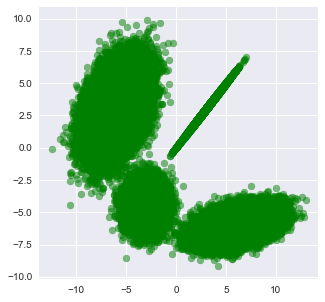

In [227]:
import pickle
with open('data.pickle', 'rb') as f:
    data_dict = pickle.load(f)
    
print(data_dict.keys)

plt.figure(figsize=(5, 5))
plt.scatter(data_dict['data'][:, 0], data_dict['data'][:, 1], c='g', alpha=0.5)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  if sys.path[0] == '':


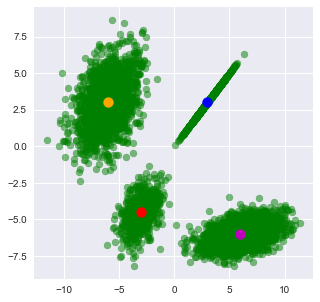

In [229]:
n_samples = 5000
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1], [-2, 1], [2, -2]]) * 3
covs = np.array([[[1, 1], [0, 1]], 
                 [[1, 1], [1, 1]],
                 [[2, 1], [1, 3]],
                 [[3, 0.5], [0.5, 0.5]]])
ps = np.array([0.1, 0.2, 0.3, 0.4])

hold_zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
hold_xs = [z[:, np.newaxis] * rng.multivariate_normal(m, cov, size=n_samples)
      for z, m, cov in zip(hold_zs, ms, covs)]
test_hold_out_data = np.sum(np.dstack(hold_xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(test_hold_out_data[:, 0], test_hold_out_data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)
plt.scatter(ms[2, 0], ms[2, 1], c='orange', s=100)
plt.scatter(ms[3, 0], ms[3, 1], c='m', s=100)

Signature: pickle.dump(obj, file, protocol=None, *, fix_imports=True)
Docstring:
Write a pickled representation of obj to the open file object file.

This is equivalent to ``Pickler(file, protocol).dump(obj)``, but may
be more efficient.

The optional *protocol* argument tells the pickler to use the given
protocol supported protocols are 0, 1, 2, 3 and 4.  The default
protocol is 3; a backward-incompatible protocol designed for Python 3.

Specifying a negative protocol version selects the highest protocol
version supported.  The higher the protocol used, the more recent the
version of Python needed to read the pickle produced.

The *file* argument must have a write() method that accepts a single
bytes argument.  It can thus be a file object opened for binary
writing, an io.BytesIO instance, or any other custom object that meets
this interface.

If *fix_imports* is True and protocol is less than 3, pickle will try
to map the new Python 3 names to the old module names used in Python
2, s